# 2 Programming problem [75 points]


For this problem, you will implement a video search method to retrieve relevant frames from a video
based on the features in a query region selected from some frame. We are providing image data and some
starter code for this assignment.

## Provided data

You can access pre–computed SIFT features here: https://filebox.ece.vt.edu/~F13ECE5554/resources/PS4_material/PS4SIFT.zip.

The associated images are stored here: https://filebox.ece.vt.edu/~F13ECE5554/resources/PS4_material/PS4Frames.zip.

Please note that the data takes about 6GB. Each .mat file in the provided SIFT data corresponds to a single
image, and contains the following variables, where `N` is the number of detected SIFT features in that image:

|   | shape | type | description |
|:-:|:-----:|:----:|:-----------:|
| descriptors | Nx128 | double | the SIFT vectors as rows |
| imname | 1x57 | char | name of the image file that goes with this data |
| numfeats | 1x1 | double | number of detected features |
| orients | Nx1 | double | the orientations of the patches |
| positions | Nx2 | double | the positions of the patch centers |
| scales | Nx1 | double | the scales of the patches |

## Provided code

The following are the provided code files. You are not required to use any of these functions, but you will
probably find them helpful.

**loadDataExample.py**: Run this code first and make sure you understand the data format. It is
a script that selects a random image, and shows how to access the descriptors. It also shows how to use
some of the other functions below.

**displaySIFTPatches.py**: given SIFT descriptor info, it returns the corners corresponding to each patch.

**getPatchFromSIFTParameters.py**: given SIFT descriptor info, it extracts the image patch itself and
returns as a single image

**selectRegion.py**: given an image and list of feature positions, it allows a user to draw a polygon
showing a region of interest, and then returns the indices within the list of positions that fell within
the polygon.

**dist2.py**: a fast implementation of computing pairwise distances between two matrices for which each
row is a data point

## Deliverables

After completing all four parts of this notebook manually export the following functions into a file name `ps4.py`:

- [ ] `match_descriptors()`
- [ ] `calculate_bag_of_words_histogram()`
- [ ] `caculate_normalized_scalar_product()`

> Note: You must include all of the imports required by your functions in the file `ps4.py`

Submit `ps4.py` and the completed version of this notebook `ps4.ipynb` to the `PS4 Code` assignment on Gradescope.

**The remaining deliverables should be added to your answer sheet and are listed in each sub-part below.**

In [1]:
import os
import glob
import imageio
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from skimage.color import rgb2gray
 
#############################################################################
# TODO: Add additional imports
#############################################################################

from displaySIFTPatches import displaySIFTPatches
from getPatchFromSIFTParameters import getPatchFromSIFTParameters
from selectRegion import roipoly
from dist2 import dist2

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### 2.1. Raw descriptor matching [15 pts]: 

In this part, we will write code to allow a user to select a region of interest in one image and then 
match descriptors from that region with descriptors in another image.

We shall display the selected region of interest in the first image (a polygon), and the matched features in the second image.The output should look similar to this:

<img src="https://www.dropbox.com/s/rd9jzz0bd3b8hxz/cv_ps4.png?raw=1" width="700" height="900"/>

> **Note: Do not use a visual vocabulary for this part.**

#### Steps:

1. Write a script `select_roi.py` that
   - loads `twoFrameData.mat`,
   - displays 'im1',
   - allows a user to select a region of interest in the image,
   - saves the selected region (i.e. an Nx2 array of polygon points) to `region.npy`,
   - and saves the indicies of the features contained within the selected region to `points.npy`.
   
> Hint: Read through `loadDataExample.py`. You will find some of the functionality you need in there.

2. Implement the `match_descriptors` function as described below.

3. Write code in this notebook to
   - load `twoFrameData.mat`, `region.npy`, and `points.npy`
   - call `match_descriptors` with the subset of descriptors from the selected region
   - generate a figure (as above) that displays the selected region in 'im1' and the corresponding feature matches in 'im2'.
   

#### Deliverables

- [ ] The function `match_descriptors` should be included when you export `ps4.py`.
- [ ] Add the figure from step 3 to your answer sheet.

In [2]:
def match_descriptors(desc1, desc2):
    """ Finds the `descriptors2` that best match `descriptors1`
    
    Inputs:
    - desc1: NxD matrix of feature descriptors
    - desc2: MxD matrix of feature descriptors

    Returns:
    - indices: the index of N descriptors from `desc2` that 
               best match each descriptor in `desc1`
    """
    N = desc1.shape[0]
    indices = np.zeros((N,), dtype="int64")
    
    ############################
    # TODO: Add your code here #
    ############################

    ssd = dist2(desc1, desc2)

    indices = np.argmin(ssd, axis=1)
    
   
    ############################
    #     END OF YOUR CODE     #
    ############################
    
    return indices

In [39]:
def draw_features(coners, ax, im):
    for j in range(len(coners)):
        ax.plot(
            [coners[j][0][1], coners[j][1][1]],
            [coners[j][0][0], coners[j][1][0]],
            color="g",
            linestyle="-",
            linewidth=1,
        )
        ax.plot(
            [coners[j][1][1], coners[j][2][1]],
            [coners[j][1][0], coners[j][2][0]],
            color="g",
            linestyle="-",
            linewidth=1,
        )
        ax.plot(
            [coners[j][2][1], coners[j][3][1]],
            [coners[j][2][0], coners[j][3][0]],
            color="g",
            linestyle="-",
            linewidth=1,
        )
        ax.plot(
            [coners[j][3][1], coners[j][0][1]],
            [coners[j][3][0], coners[j][0][0]],
            color="g",
            linestyle="-",
            linewidth=1,
        )
    ax.set_xlim(0, im.shape[1])
    ax.set_ylim(0, im.shape[0])
    plt.gca().invert_yaxis()
    plt.show()

[1336  729 1571 1616   63   47  939  660  794  513   69  156  471 1517
  608  111 1614   69 1635  231  237  709  107  158   33 1346  246  305
 1413   69  856  820  949  233  330    8  338 1666  176  101  161  243
 1358  679  731  298  174  569 1325 1224 1390 1365 1694  947  291 1129
 1422  647  319  753  682  468  623 1166 1080  147  478  216 1124  877
    9 1564  439 1545  769 1176  917  442  280 1194  936 1215  673  675
  237 1389  877  526  681  800 1694 1353  834  974  121  288 1669 1177
  657 1490  905 1324 1530 1714  725 1163 1507 1506   52  788 1660  594
  770  808 1206  918  159 1620 1158  210  229  919 1373  958 1211  133
  806   14  341 1144  113  481   45  147 1530  163  631 1110  683  916
  593  276  651  804 1281  343  344  198  505 1557  244  383 1401 1048
  409 1429 1394 1431 1399 1423 1486 1411 1412 1404 1092 1093 1093 1496
 1482 1483 1421 1418 1417 1421 1399 1247 1487 1413 1485 1412 1413 1478
 1092 1432 1059 1050 1722 1471 1470 1215  743  604  956  552  192  845
 1562 

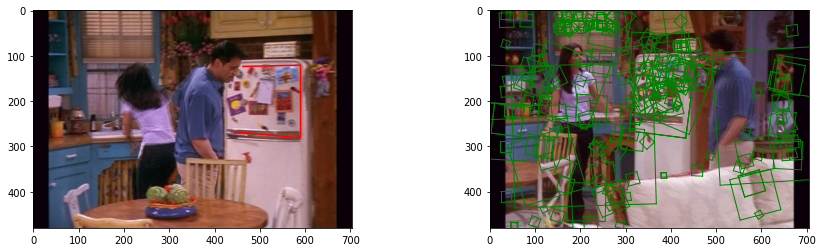

In [5]:
####################################################################
# TODO: Write code to complete the steps described above.          #
####################################################################

mat = scipy.io.loadmat("twoFrameData.mat")
im1 = mat["im1"]
im2 = mat["im2"]
descriptors1 = mat["descriptors1"]
descriptors2 = mat["descriptors2"]

indices1 = np.load("points.npy")
region1 = np.load("region.npy")

line = plt.Line2D(region1[:, 0], region1[:, 1], color="r")

indices2 = match_descriptors(descriptors1[indices1], descriptors2)
print(indices2)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
axs[0].imshow(im1)
axs[0].add_line(line)

axs[1].imshow(im2)
coners = displaySIFTPatches(
    mat["positions2"][indices2],
    mat["scales2"][indices2],
    mat["orients2"][indices2],
)
draw_features(coners,axs[1], im2)


####################################################################
#                        END OF YOUR CODE                          #
####################################################################

### 2.2. Visualizing the vocabulary [20 pts]:

In this part we will build a visual vocabulary.

#### Steps

1. Cluster a large, representative random sample of SIFT descriptors from some portion of the frames using k-means. Let the `k` centers be the visual words. The value of `k` is a free parameter. For this data something like `k = 1500` should work, but feel free to play with this parameter. For clustering, refer to `kmeans` function in **sklearn**. 

   > **Note:** You may run out of memory if you use all the provided SIFT descriptors to build the vocabulary.

   Save the cluster centers to `vocabulary.npy` so that you can use the vocabulary again in other parts of the assignment.


2. Display example image patches associated with any two of the visual words i.e choose raw SIFT descriptors that are nearest to each of the chosen visual words. Choose the two words such that they are distinct to illustrate what the different words are capturing, and display enough patch examples so the word content is evident (e.g., 25 patches per word). 

> Refer to the helper functions `getPatchFromSIFTParameters.py` to display patches and `dist2.py` for fast distance computation.


3. Describe what you see in your answer sheet

#### Deliverables

- [ ] Display patches corresponding with two visual words in your answer sheet.
- [ ] Discuss the results in your answer sheet.

In [6]:
####################################################################
# TODO: Write code to complete the steps described above.          #
####################################################################

siftdir = "/Users/ishanarya/Desktop/school/cv/ps/ps4/sift/"

fnames = glob.glob(siftdir + "*.mat")
fnames = [os.path.basename(name) for name in fnames]
fnames = np.random.choice(fnames, size=500)

mats = list(map(lambda fname: scipy.io.loadmat(os.path.join(siftdir, fname)), fnames))

descriptors = mats[0]["descriptors"]

print("Starting join.")

for mat in mats:
    descriptors = np.append(descriptors, mat["descriptors"], axis=0)

descriptors = descriptors[1:]

print("Finished join.")

print(descriptors)

print("starting kmeans.")

kmeans = MiniBatchKMeans(n_clusters=1500, batch_size=500).fit(descriptors)

print("finished kmeans fitting")

np.save("vocabulary.npy", kmeans.cluster_centers_)



####################################################################
#                        END OF YOUR CODE                          #
####################################################################

Starting join.
[[0.07864787 0.         0.         ... 0.0019662  0.         0.        ]
 [0.01771647 0.         0.         ... 0.         0.         0.        ]
 [0.00785917 0.00196479 0.01768313 ... 0.00982396 0.         0.        ]
 ...
 [0.01766592 0.0098144  0.         ... 0.02748031 0.00392576 0.00392576]
 [0.0255491  0.00196532 0.00196532 ... 0.         0.         0.        ]
 [0.02943095 0.00196206 0.         ... 0.10791348 0.00196206 0.        ]]
starting kmeans.
finished kmeans fitting


In [3]:
framesdir = "/Users/ishanarya/Desktop/school/cv/ps/ps4/frames/"
siftdir = "/Users/ishanarya/Desktop/school/cv/ps/ps4/sift/"

print("Getting fnames.")

fnames = glob.glob(siftdir + "*.mat")
fnames = [os.path.basename(name) for name in fnames]

N = len(fnames)

print("Getting mats.")

mats = list(map(lambda fname: scipy.io.loadmat(os.path.join(siftdir, fname)), fnames))

print("Getting image factors.")

descriptors = [mat["descriptors"] for mat in mats]
positions = [mat["positions"] for mat in mats]
scales = [mat["scales"] for mat in mats]
orients = [mat["orients"] for mat in mats]

print("Concatenating image factors.")

descriptors = np.concatenate(descriptors, axis=0)
positions = np.concatenate(positions, axis=0)
scales = np.concatenate(scales, axis=0)
orients = np.concatenate(orients, axis=0)

print("Setup!")

Getting fnames.
Getting mats.
Getting image factors.
Concatenating image factors.
Setup!


In [20]:
print("Getting vwords.")

vocabs = np.load("vocabulary.npy")

vword0 = np.array([vocabs[13]])
vword1 = np.array([vocabs[130]])

print("Getting distances.")

ssd0 = dist2(vword0, descriptors)[0]
ssd1 = dist2(vword1, descriptors)[0]

print("Getting closest descriptors.")

closest_descriptors0 = np.argpartition(ssd0, 25)[:25]
closest_descriptors1 = np.argpartition(ssd1, 25)[:25]

print("Saving descriptors.")

np.save("clst_descrip0.npy", closest_descriptors0)
np.save("clst_descrip1.npy", closest_descriptors1)


Getting fnames.
Getting mats.
Getting image factors.
Concatenating image factors.
Getting vwords.
Getting distances.
Getting closest descriptors.
Saving descriptors.


In [3]:
closest_descriptors0 = np.load("clst_descrip0.npy")
closest_descriptors1 = np.load("clst_descrip1.npy")

In [23]:
print(closest_descriptors0)
print(len(closest_descriptors0))
print(closest_descriptors1)
print(len(closest_descriptors1))

print(len(descriptors))

[ 200011 1303554 2091335 5109168 6528479 6390129 3041814 6944088 4932266
 6836521  444336 2637631 2730405 4208327 5738144   13529 1413517 3373598
 1047004 5745119 5515629 5182386 5352757 1877527 3001491]
25
[4214087   25928 1374649 1650984  270557  748621  947009 4539394 6265153
 6363221 5198266 6212678  110455 6731192 3264779 5304910 4273123 6221689
 6795374 7363449  202323 4097959 1867493 7033380  714759]
25
[1.11366642 0.75875102 0.69071722 ... 0.36410703 0.32224084 0.48103447]
7391458


In [9]:
frame_lengths = []

frame_sum = 0

for mat in mats:
    frame_sum += mat["descriptors"].shape[0]
    frame_lengths.append(frame_sum)

def num2pic(num):
    for i in range(len(frame_lengths)):
        if num < frame_lengths[i]:
            return i
    return -1




Starting image patches.
Starting with vocab 13.


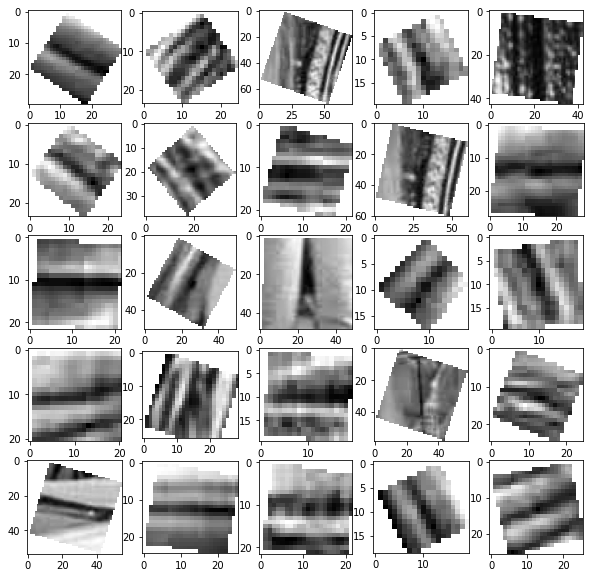

Starting with vocab 130.


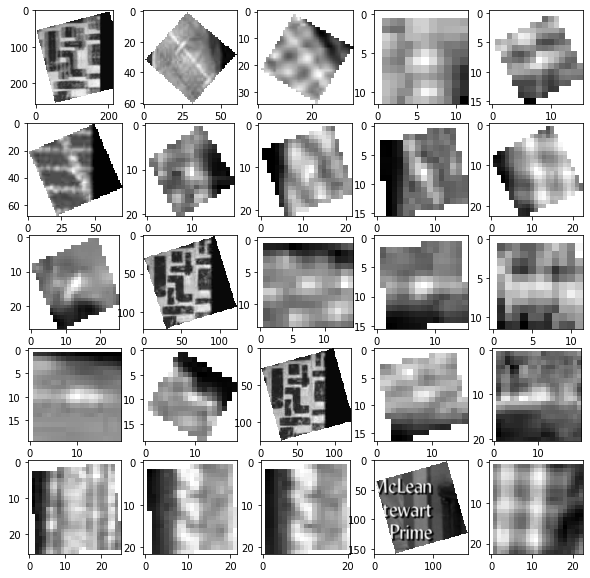

In [12]:
print("Starting image patches.")

fig, axs = plt.subplots(5,5)
fig.set_figwidth(10)
fig.set_figheight(10)

print("Starting with vocab 13.")

for i in range(closest_descriptors0.shape[0]):
    j = i//5
    k = i%5

    patch_num = closest_descriptors0[i]

    im_num = num2pic(patch_num)

    im = imageio.imread(os.path.join(framesdir, fnames[im_num][:-4]))

    img_patch = getPatchFromSIFTParameters(
        positions[patch_num, :],
        scales[patch_num],
        orients[patch_num],
        rgb2gray(im),
    )

    axs[j, k].imshow(img_patch, cmap="gray")

plt.show()



fig, axs = plt.subplots(5,5)
fig.set_figwidth(10)
fig.set_figheight(10)

print("Starting with vocab 130.")

for i in range(closest_descriptors1.shape[0]):
    j = i//5
    k = i%5

    patch_num = closest_descriptors1[i]

    im_num = num2pic(patch_num)

    im = imageio.imread(os.path.join(framesdir, fnames[im_num][:-4]))

    img_patch = getPatchFromSIFTParameters(
        positions[patch_num, :],
        scales[patch_num],
        orients[patch_num],
        rgb2gray(im),
    )

    axs[j, k].imshow(img_patch, cmap="gray")

plt.show()

### 2.3.  Full frame queries [20 pts]:

In this part we will use our visual vocabulary to perfom frame queries.

#### Steps

1. Map an image’s features into its bag-of-words histogram. The histogram for image *$I_j$* is a k-dimensional vector:

   $$F(I_j) = [freq_{1,j}, freq_{2,j}, ....., freq_{k,j}]$$

   where each entry *$freq_{i,j}$* counts the number of occurrences of the i-th visual word in that image, and `k` is the number of total words in the vocabulary.
   
   In other words, a single image’s list of `N` **SIFT** descriptors yields a `k-dimensional` bag of words histogram.


2. Compute similarity scores. Compare two bag-of-words histograms using the normalized scalar product:

   $$S(I_i,I_j) = \frac{F(I_i) \cdot F(I_j)}{||F(I_i)||||F(I_j)||} = \frac{1}{||F(I_i)||||F(I_j)||} \sum_{m=1}^{k} freq_{m,i}freq_{m,j}$$

   where $S()$ is the similarity score. $||F(I_i)||$ is the `L2` norm of $F(I_i)$.


3. Sort the similarity scores between a query histogram and the histograms associated with the rest of the images in the video. Pull up the images associated with the `M` most similar examples.


4. After testing your code for bag-of-words visual search, choose 3 diﬀerent frames from the entire video dataset to serve as queries. 


5. Display the `M=5` most similar frames to each of these queries (in rank order) based on the normalized scalar product between their bag of words histograms. 


6. Explain the results in your answer sheet.

#### Deliverables

- [ ] The function `calculate_bag_of_words_histogram` should be included when you export `ps4.py`.
- [ ] The function `caculate_normalized_scalar_product` should be included when you export `ps4.py`.
- [ ] Display `3` different query frames and the `M=5` most similar frames from the video dataset (don't include the query in the results) in your answer sheet.
- [ ] Explain the results in your answer sheet.

In [4]:
def calculate_bag_of_words_histogram(vocabulary, descriptors):
    """ Calculate the bag-of-words histogram for the given frame descriptors.
    
    Inputs:
    - vocabulary: kxd array representing a visual vocabulary
    - descriptors: nxd array of frame descriptors
    
    Outputs:
    - histogram: k-dimensional bag-of-words histogram
    """
    k = vocabulary.shape[0]
    histogram = np.zeros((k,), dtype="int64")

    ############################
    # TODO: Add your code here #
    ############################
    
    ssd = dist2(descriptors, vocabulary)

    nearest_vocabs = np.argmin(ssd, axis=1)

    histogram = np.bincount(nearest_vocabs)

    histogram = np.append(histogram, np.zeros((k - histogram.size), dtype=np.int_))


    ############################
    #     END OF YOUR CODE     #
    ############################

    return histogram

In [26]:
def caculate_normalized_scalar_product(hist1, hist2):
    """ Caculate the normalized scalar product between two histograms.
    
    Inputs:
    - hist1: k-dimensional array
    - hist2: k-dimensional array
    
    Outputs:
    - score: the normalized scalar product described above
    """
    
    ############################
    # TODO: Add your code here #
    ############################

    return np.dot(hist1, hist2).astype(np.float_)/(np.linalg.norm(hist1) * np.linalg.norm(hist2) + 0.0000000000000001)

    
    ############################
    #     END OF YOUR CODE     #
    ############################
    

In [8]:
vocabs = np.load("vocabulary.npy")

print("Setting up descriptor hists.")

descriptor_hists = [calculate_bag_of_words_histogram(vocabs, mat["descriptors"]) for mat in mats]
np.save("descriptor_hists.npy", descriptor_hists)

Setting up descriptor hists.
Frame 1 Comparison
[5066 3026 5060   13    5  605]


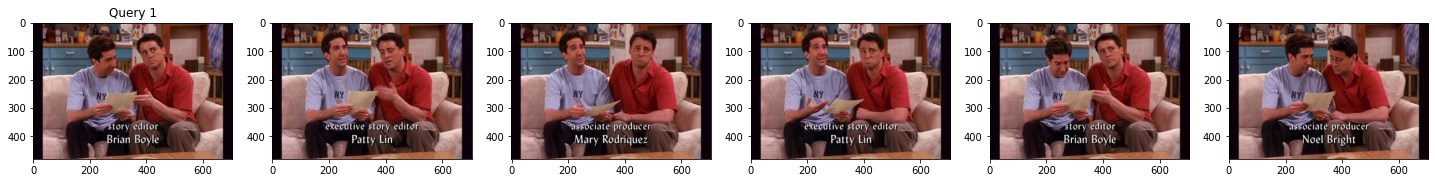

[1296 4684  375  113  110 2476]


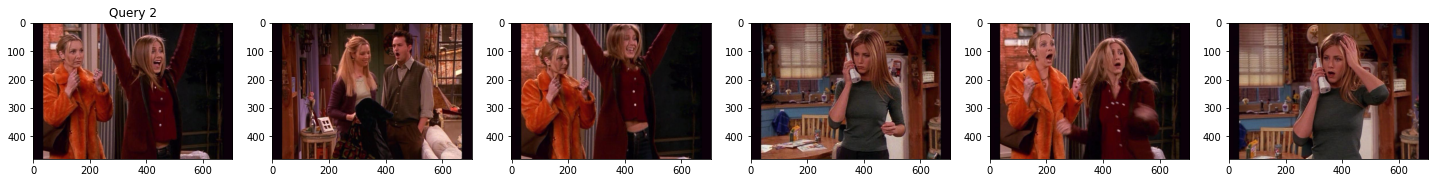

[3427  624 2640   75 2507 2630]


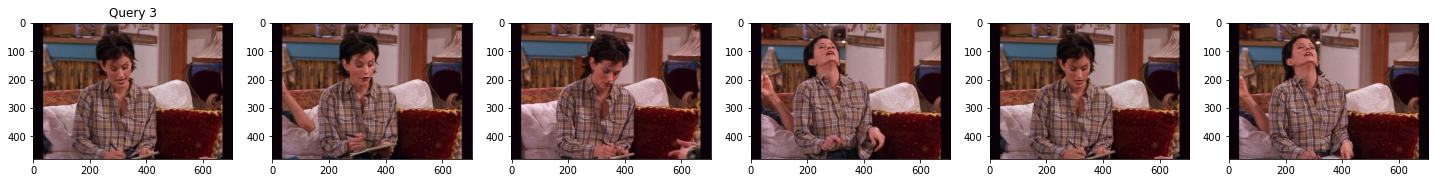

In [36]:
####################################################################
# TODO: Write code to complete the steps described above. Make     #
# sure you use your `calculate_bag_of_words_histogram` and         #
# `caculate_normalized_scalar_product` functions.                  #
####################################################################

vocabs = np.load("vocabulary.npy")

print("Setting up descriptor hists.")

descriptor_hists = np.load("descriptor_hists.npy")

frame1 = 13
frame2 = 110
frame3 = 75
frame1_hist = descriptor_hists[frame1]
frame2_hist = descriptor_hists[frame2]
frame3_hist = descriptor_hists[frame3]

print("Frame 1 Comparison")

distances = [caculate_normalized_scalar_product(frame1_hist, hist) for hist in descriptor_hists]
frame1_closest = np.argpartition(distances, len(distances) - 6)[-6:]
print(frame1_closest)

fig, axs = plt.subplots(1, 6)
fig.set_figwidth(25)
fig.set_figheight(25)

im = imageio.imread(os.path.join(framesdir, fnames[frame1][:-4]))
axs[0].imshow(im)
axs[0].set_title("Query 1")

j = 1
for im_num in frame1_closest:
    if im_num == frame1:
        continue
    im = imageio.imread(os.path.join(framesdir, fnames[im_num][:-4]))
    axs[j].imshow(im) 
    j += 1

plt.show()



distances = [caculate_normalized_scalar_product(frame2_hist, hist) for hist in descriptor_hists]
frame2_closest = np.argpartition(distances, len(distances) - 6)[-6:]
print(frame2_closest)

fig, axs = plt.subplots(1, 6)
fig.set_figwidth(25)
fig.set_figheight(25)

im = imageio.imread(os.path.join(framesdir, fnames[frame2][:-4]))
axs[0].imshow(im)
axs[0].set_title("Query 2")

j = 1
for im_num in frame2_closest:
    if im_num == frame2:
        continue
    im = imageio.imread(os.path.join(framesdir, fnames[im_num][:-4]))
    axs[j].imshow(im) 
    j += 1

plt.show()



distances = [caculate_normalized_scalar_product(frame3_hist, hist) for hist in descriptor_hists]
frame3_closest = np.argpartition(distances, len(distances) - 6)[-6:]
print(frame3_closest)

fig, axs = plt.subplots(1, 6)
fig.set_figwidth(25)
fig.set_figheight(25)

im = imageio.imread(os.path.join(framesdir, fnames[frame3][:-4]))
axs[0].imshow(im)
axs[0].set_title("Query 3")

j = 1
for im_num in frame3_closest:
    if im_num == frame3:
        continue
    im = imageio.imread(os.path.join(framesdir, fnames[im_num][:-4]))
    axs[j].imshow(im) 
    j += 1

plt.show()




####################################################################
#                        END OF YOUR CODE                          #
####################################################################

### 2.4.  Region queries [20 pts]:

In this step we will use regions of interest within an image to query frames from the video.

#### Steps

1. Form a query from a region within a frame. Select a polygonal region interactively with the mouse, and compute a bag of words histogram from only the SIFT descriptors that fall within that region.  Optionally, you may weight it with tf-idf.

   > You may want to reuse your `select_roi.py` script here.


2. Select your favorite query regions from within 4 frames (which may be diﬀerent than those used above) to demonstrate the retrieved frames when only a portion of the SIFT descriptors are used to form a bag of words. 

   > Try to include example(s) where the same object is found in the **most similar M frames** but amidst diﬀerent objects or backgrounds, and also **include a failure case**. 

3. Explain the results, including possible reasons for the failure cases in your answer sheet.

#### Deliverables

- [ ] Display the selected query region and the `M=5` most similar frames for `4` different queries in your answer sheet.
- [ ] Explain the results in your answer sheet.

[3040 6526 6529 1232 4518   13]


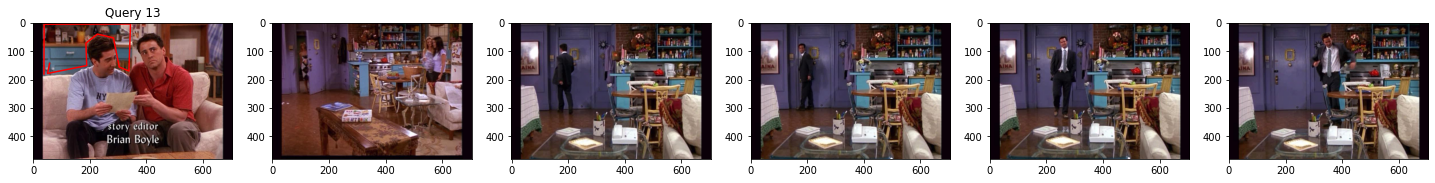

[2859 4011 1122 2600 2590 5474]


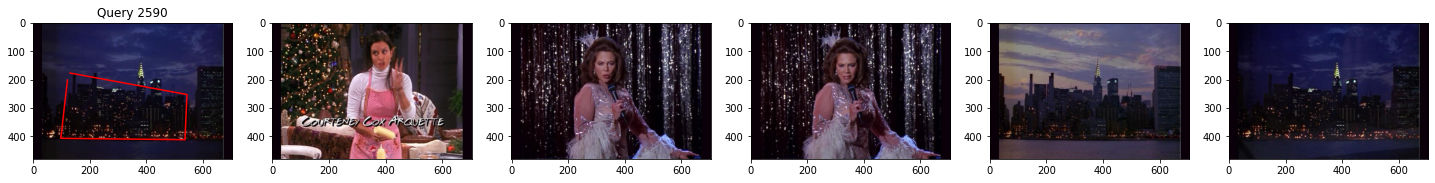

[6489  672 4419 4428  685 5194]


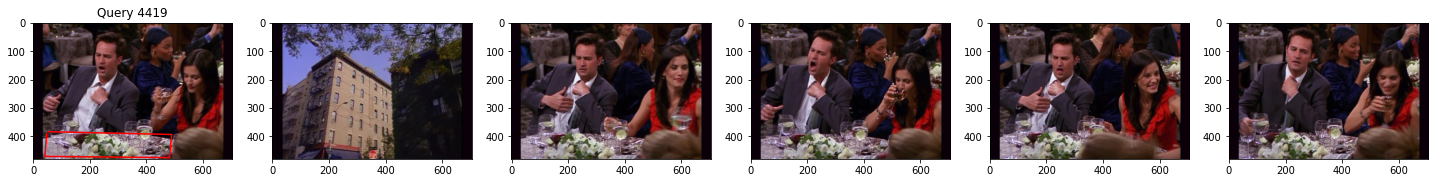

[3919  389 6348 4900 1772 1388]


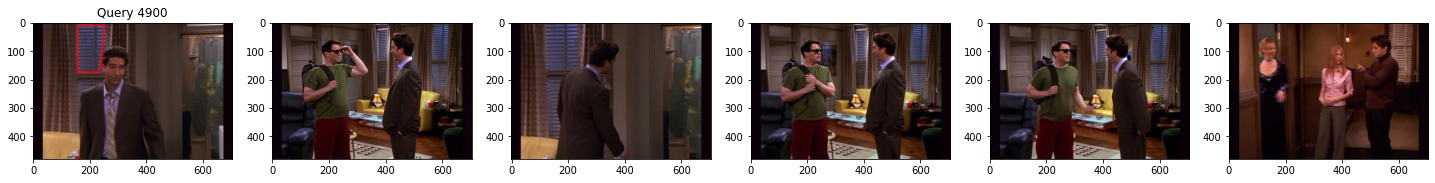

In [48]:
####################################################################
# TODO: Write code to complete the steps described above.          #
####################################################################

frames = [13, 2590, 4419, 4900]

for frame in frames:
    region_name = "region" + str(frame) + ".npy"
    points_name = "points" + str(frame) + ".npy"
    region = np.load(region_name)
    indices = np.load(points_name)
    mat = mats[frame]
    frame_hist = calculate_bag_of_words_histogram(vocabs, mat["descriptors"][indices])

    distances = [caculate_normalized_scalar_product(frame_hist, hist) for hist in descriptor_hists]

    frame_closest = np.argpartition(distances, len(distances) - 6)[-6:]

    print(frame_closest)

    line = plt.Line2D(region[:, 0], region[:, 1], color="r")

    fig, axs = plt.subplots(1, 6)
    fig.set_figwidth(25)
    fig.set_figheight(25)

    im = imageio.imread(os.path.join(framesdir, fnames[frame][:-4]))
    axs[0].imshow(im)
    axs[0].add_line(line)
    axs[0].set_title("Query " + str(frame))

    j = 1
    for im_num in frame_closest:
        if im_num == frame or j > 5:
            continue
        im = imageio.imread(os.path.join(framesdir, fnames[im_num][:-4]))
        axs[j].imshow(im) 
        j += 1

    plt.show()




####################################################################
#                        END OF YOUR CODE                          #
####################################################################